# Endocrine and Metabolism (PHAR1019)
# Experimental Design Workshop

## 1. Workbook Introduction

### 1.1. Preamble

This is a workbook file for the Endocrine and Metabolism (PHAR1019) Experimental Design workshop.

It contains interactive elements that are designed to help students explore fundamental concepts of experimental design.

The workbook is built with a programming language called Python. It can be interacted with without any previous knowledge of programming languages or coding using a web-browser interface called JupyterLite.

**You are not expected to write or understand code. Focus on interpreting results and making design choices.**

### 1.2. Learning Objectives
- Explain parameters relevant for experimental design tasks
- Understand design choices for experimental design
- Critically interpret and evaluate data
- Develop an experimental design
- Develop familiarity with computational thinking

### 1.3. How to use this notebook
1. Access the workbook via this web-address: [https://mzelzer.github.io/EAM-PHAR1019-Experimental-Design-Workshop/](https://mzelzer.github.io/EAM-PHAR1019-Experimental-Design-Workshop/)
2. Select the *Python kernel* called **Pyodide** if prompted.
3. In the menu bar at the top, click **Run → Run All Cells**.
4. You are not expected to write Python from scratch — focus on interpreting results and making design choices.

### 1.4. Supporting Code

Throughout the workbook, we will use functions and other supporting code to illustrate concepts. This needs to be set up AND executed at the beginning of the workbook.

#### 1.4.1 Import Packages

Here, a series of codes is run to tell the software what programs (packages or libraries) are required to run the rest of the workbook. 

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress, pearsonr
import matplotlib.pyplot as plt

#### 1.4.2. Setting up the programming functions

Next, programs (functions) that are specific to this workbook are defined. This code is particularly long and has been hidden from view to keep the workbook tidy.

#### 1.4.2.1. Plotting functions

This code provides functions that help with plotting data.

We will use these functions later to visualise data that we generate.

In [2]:
def pressure_to_df(times_s, glucose_mg_ml, pressure):
    R, T, G = pressure.shape
    return pd.DataFrame({
        "replicate": np.repeat(np.arange(1, R + 1), T * G),
        "time_s": np.tile(np.repeat(times_s, G), R),
        "glucose_mg_ml": np.tile(np.tile(glucose_mg_ml, T), R),
        "pressure_mmH2O": pressure.reshape(-1),
    })


def plot_pressure_vs_glucose(
    df,
    time_s=60.0,
    rep=1,
    show_regression=True
):
    """
    Plot pressure vs glucose concentration at a fixed time point,
    including linear regression and correlation statistics.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns:
        ['replicate', 'time_s', 'glucose_mg_ml', 'pressure_mmH2O']
    time_s : float
        Time point to plot (seconds)
    rep : int
        Replicate number (1-based)
    show_regression : bool
        Whether to overlay linear regression
    """

    df_plot = (
        df[(df["time_s"] == time_s) & (df["replicate"] == rep)]
        .sort_values("glucose_mg_ml")
    )

    x = df_plot["glucose_mg_ml"].values
    y = df_plot["pressure_mmH2O"].values

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y)

    if show_regression and len(x) > 2:
        # Linear regression
        res = linregress(x, y)
        y_fit = res.intercept + res.slope * x

        # Correlation
        r, p = pearsonr(x, y)

        plt.plot(x, y_fit)

        stats_text = (
            f"Slope = {res.slope:.2f}\n"
            f"Intercept = {res.intercept:.1f}\n"
            f"$R^2$ = {res.rvalue**2:.3f}\n"
            f"r = {r:.3f}\n"
            f"p = {p:.2e}"
        )

        plt.text(
            0.05, 0.95,
            stats_text,
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", alpha=0.9)
        )

    plt.xlabel("Glucose concentration (mg/mL)")
    plt.ylabel("Pressure (mm H₂O)")
    plt.title(f"Pressure vs glucose concentration at t = {time_s:.0f} s")
    plt.tight_layout()
    plt.show()


def plot_pressure_timecourses(times_s, glucose_mg_ml, pressure, rep=0):
    pressure = np.asarray(pressure)
    if pressure.ndim == 2:
        pressure = pressure[None, :, :]  # add replicate axis
    P = pressure[rep]
    plt.figure()
    for j, g in enumerate(glucose_mg_ml):
        plt.plot(times_s, P[:, j], marker="o", label=f"{g:g} mg/mL")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H2O)")
    plt.title("Pressure as a function of glucose concentration")
    plt.legend()
    plt.show()


def plot_pressure_by_temperature(times_s, temps_C, pressure_T, glucose_mg_ml, glucose_value=80, rep=0):
    glucose_mg_ml = np.asarray(glucose_mg_ml, dtype=float)
    temps_C = np.asarray(temps_C, dtype=float)

    # robust index: choose the closest glucose value
    g_idx = int(np.argmin(np.abs(glucose_mg_ml - float(glucose_value))))
    g_val = glucose_mg_ml[g_idx]

    # Expect shape: (rep, time, glucose, temp)
    assert pressure_T.ndim == 4, f"Expected 4D array, got shape {pressure_T.shape}"
    assert pressure_T.shape[2] == glucose_mg_ml.size, (
        f"Glucose axis mismatch: pressure_T.shape[2]={pressure_T.shape[2]} vs "
        f"len(glucose_mg_ml)={glucose_mg_ml.size}"
    )
    assert pressure_T.shape[3] == temps_C.size, (
        f"Temp axis mismatch: pressure_T.shape[3]={pressure_T.shape[3]} vs len(temps_C)={temps_C.size}"
    )

    plt.figure(figsize=(7, 5))
    for k, T in enumerate(temps_C):
        plt.plot(times_s, pressure_T[rep, :, g_idx, k], marker="o", label=f"{T:g} °C")

    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H₂O)")
    plt.title(f"Pressure vs time at ~{g_val:g} mg/mL (requested {glucose_value:g})")
    plt.legend(ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()


def linregress_np(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    slope, intercept = np.polyfit(x, y, 1)
    y_hat = slope * x + intercept

    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    r = np.corrcoef(x, y)[0, 1] if x.size > 1 else np.nan

    return slope, intercept, r2, r


def plot_linear_region(
    times_s,
    glucose_mg_ml,
    pressure_35,
    glucose_value,
    t_min,
    t_max,
    rep=0
):
    pressure = np.asarray(pressure_35)
    if pressure.ndim == 3:
        pressure = pressure[rep]  # (time, glucose)

    # choose glucose index
    g_idx = int(np.argmin(np.abs(np.asarray(glucose_mg_ml) - glucose_value)))
    y = pressure[:, g_idx]

    # window mask
    mask = (times_s >= t_min) & (times_s <= t_max)
    xw = times_s[mask]
    yw = y[mask]

    plt.figure(figsize=(8.5, 4.8))

    # full timecourse
    plt.plot(
        times_s, y,
        marker="o",
        alpha=0.35,
        label="All data"
    )

    # selected window
    plt.plot(
        xw, yw,
        marker="o",
        label="Selected window"
    )

    if xw.size >= 2:
        slope, intercept, r2, r = linregress_np(xw, yw)
        y_fit = slope * xw + intercept

        plt.plot(
            xw, y_fit,
            linewidth=3,
            label="Linear fit"
        )

        stats = (
            f"Glucose = {glucose_mg_ml[g_idx]:g} mg/mL\n"
            f"Window = {t_min:g}–{t_max:g} s\n"
            f"Slope = {slope:.3f} mm H₂O/s\n"
            f"$R^2$ = {r2:.3f}\n"
            f"r = {r:.3f}\n"
            f"n = {xw.size}"
        )
    else:
        stats = "Select at least two time points."

    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H₂O)")
    plt.title("Selecting a linear region of the pressure timecourse")

    # ---- legend OUTSIDE the plot ----
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

    # ---- stats box INSIDE, but readable ----
    plt.text(
        0.02, 0.98,
        stats,
        transform=plt.gca().transAxes,
        va="top",
        fontsize=10,
        bbox=dict(
            boxstyle="round",
            facecolor="white",
            edgecolor="0.3",
            alpha=0.9
        )
    )

    plt.tight_layout(rect=[0, 0, 0.82, 1])  # leave space for legend
    plt.show()


def linregress_np(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    slope, intercept = np.polyfit(x, y, 1)
    y_hat = slope * x + intercept

    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    r = np.corrcoef(x, y)[0, 1] if x.size > 1 else np.nan

    return slope, intercept, r2, r

def fit_linear_regions(df_35, linear_windows, rep=1):
    """
    (i) Clip df_35 to per-glucose linear windows
    (ii) Perform linear fits
    Returns:
      df_clip (clipped points)
      results_df (table with slopes etc.)
    """
    rows = []
    clipped_parts = []

    for g, (tmin, tmax) in linear_windows.items():
        df_g = df_35[
            (df_35["replicate"] == rep) &
            (df_35["glucose_mg_ml"].astype(float) == float(g)) &
            (df_35["time_s"] >= float(tmin)) &
            (df_35["time_s"] <= float(tmax))
        ].copy()

        df_g = df_g.sort_values("time_s")
        clipped_parts.append(df_g)

        x = df_g["time_s"].to_numpy()
        y = df_g["pressure_mmH2O"].to_numpy()

        if len(x) >= 2:
            slope, intercept, r2, r = linregress_np(x, y)
        else:
            slope, intercept, r2, r = np.nan, np.nan, np.nan, np.nan

        rows.append({
            "glucose_mg_ml": float(g),
            "t_min_s": float(tmin),
            "t_max_s": float(tmax),
            "n_points": int(len(x)),
            "slope_mmH2O_per_s": slope,
            "intercept_mmH2O": intercept,
            "R2": r2,
            "r": r,
        })

    df_clip = pd.concat(clipped_parts, ignore_index=True)
    results_df = pd.DataFrame(rows).sort_values("glucose_mg_ml").reset_index(drop=True)
    return df_clip, results_df

def plot_linear_fits_single_figure(df_clip, results_df, rep=1):
    """
    (iii) Plot all clipped datapoints + their fitted lines in ONE plot
    """
    plt.figure(figsize=(8.5, 5.2))

    for _, row in results_df.iterrows():
        g = row["glucose_mg_ml"]
        tmin, tmax = row["t_min_s"], row["t_max_s"]
        slope, intercept = row["slope_mmH2O_per_s"], row["intercept_mmH2O"]

        df_g = df_clip[
            (df_clip["replicate"] == rep) &
            (df_clip["glucose_mg_ml"].astype(float) == float(g))
        ].sort_values("time_s")

        x = df_g["time_s"].to_numpy()
        y = df_g["pressure_mmH2O"].to_numpy()

        # points used for fit
        plt.plot(x, y, marker="o", linestyle="none", label=f"{g:g} mg/mL (fit pts)")

        # fitted line across the window
        if np.isfinite(slope) and np.isfinite(intercept):
            x_line = np.array([tmin, tmax], dtype=float)
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=2.5)

    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H₂O)")
    plt.title("Linear-region fits for each glucose concentration (35 °C)")
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout(rect=[0, 0, 0.78, 1])
    plt.show()



def plot_pressure_rate_vs_glucose(rates_table):
    import numpy as np
    import matplotlib.pyplot as plt
    from math import erf, sqrt

    x = rates_table["glucose_mg_ml"].to_numpy(dtype=float)
    y = rates_table["slope_mmH2O_per_s"].to_numpy(dtype=float)
    n = len(x)

    plt.figure(figsize=(7.5, 5.5))

    # Scatter + fit
    plt.scatter(x, y, s=70, zorder=3)
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    plt.plot(x, y_fit, linewidth=2.5)

    # Correlation
    r = np.corrcoef(x, y)[0, 1]
    r2 = r ** 2

    # ---- p-value for r (normal approximation) ----
    if n > 2 and abs(r) < 1:
        t_stat = r * sqrt((n - 2) / (1 - r**2))
        # two-sided p-value from normal CDF
        p_val = 2 * (1 - 0.5 * (1 + erf(abs(t_stat) / sqrt(2))))
    else:
        p_val = np.nan

    plt.xlabel("Glucose concentration (mg/mL)")
    plt.ylabel("Pressure rate (mm H₂O / s)")
    plt.title("Pressure rate vs glucose concentration\n(derived from linear regions)")

    # ---- stats BELOW the plot ----
    stats_text = (
        f"Slope = {slope:.4f} (mm H₂O s⁻¹)/(mg mL⁻¹)    "
        f"$R^2$ = {r2:.3f}    "
        f"r = {r:.3f}    "
        f"p ≈ {p_val:.3g}"
    )

    plt.gca().text(
        0.5, -0.30,
        stats_text,
        transform=plt.gca().transAxes,
        ha="center",
        va="top",
        bbox=dict(
            boxstyle="round",
            facecolor="white",
            edgecolor="0.3",
            alpha=0.95
        )
    )

    plt.tight_layout(rect=[0, 0.14, 1, 1])
    plt.show()


def plot_temperature_effects_at_glucose(
    times_s,
    glucose_mg_ml,
    temps_C,
    pressure_T,
    glucose_value=60.0,
    rep=0,
    t_min=120.0,
    t_max=300.0
):
    """
    Two-panel plot:
      (A) Pressure timecourses vs time for different temperatures
      (B) Pressure rate vs temperature
    """

    # robust glucose index
    g_idx = int(np.argmin(np.abs(np.asarray(glucose_mg_ml, dtype=float) - glucose_value)))
    g_val = float(glucose_mg_ml[g_idx])

    # compute rates
    rates = []
    for t_idx, T in enumerate(temps_C):
        y = pressure_T[rep, :, g_idx, t_idx]
        mask = (times_s >= t_min) & (times_s <= t_max)
        xw = times_s[mask]
        yw = y[mask]
        slope, intercept, r2, r = linregress_np(xw, yw)
        rates.append(slope)

    # plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

    # (A) Pressure timecourses
    ax = axes[0]
    for t_idx, T in enumerate(temps_C):
        y = pressure_T[rep, :, g_idx, t_idx]
        ax.plot(times_s, y, marker="o", label=f"{T:g} °C")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pressure (mm H₂O)")
    ax.set_title(f"Pressure vs time\n(glucose ≈ {g_val:g} mg/mL)")
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    # (B) Pressure rate vs temperature
    ax = axes[1]
    ax.plot(temps_C, rates, marker="o")
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Pressure rate (mm H₂O / s)")
    ax.set_title(f"Pressure rate vs temperature\n(window {t_min:g}–{t_max:g} s)")

    plt.tight_layout()
    plt.show()


def plot_pressure_rate_heatmap(
    df_rates_2d,
    cmap="viridis"
):
    """
    Plot a heatmap of pressure rate across the
    glucose–temperature design space.

    Parameters
    ----------
    df_rates_2d : pandas.DataFrame
        Must contain columns:
        - glucose_mg_ml
        - temperature_C
        - pressure_rate_mmH2O_per_s
    cmap : str
        Matplotlib colormap
    """

    # extract unique sorted axes
    glucose_vals = np.sort(df_rates_2d["glucose_mg_ml"].unique())
    temp_vals = np.sort(df_rates_2d["temperature_C"].unique())

    # build 2D array: rows = temperature, columns = glucose
    Z = np.full((len(temp_vals), len(glucose_vals)), np.nan)

    for i, T in enumerate(temp_vals):
        for j, g in enumerate(glucose_vals):
            mask = (
                (df_rates_2d["temperature_C"] == T) &
                (df_rates_2d["glucose_mg_ml"] == g)
            )
            if mask.any():
                Z[i, j] = df_rates_2d.loc[mask, "pressure_rate_mmH2O_per_s"].values[0]

    # plot heatmap
    plt.figure(figsize=(7.5, 5.5))
    im = plt.imshow(
        Z,
        origin="lower",
        aspect="auto",
        cmap=cmap
    )

    # axis ticks and labels
    plt.xticks(
        ticks=np.arange(len(glucose_vals)),
        labels=[f"{g:g}" for g in glucose_vals]
    )
    plt.yticks(
        ticks=np.arange(len(temp_vals)),
        labels=[f"{T:g}" for T in temp_vals]
    )

    plt.xlabel("Glucose concentration (mg/mL)")
    plt.ylabel("Temperature (°C)")
    plt.title("Pressure rate across glucose–temperature design space")

    # colourbar
    cbar = plt.colorbar(im)
    cbar.set_label("Pressure rate (mm H₂O / s)")

    plt.tight_layout()
    plt.show()



def plot_3d_design_space_rates(df_rates_3d):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    x = df_rates_3d["glucose_mg_ml"].to_numpy(dtype=float)
    y = df_rates_3d["temperature_C"].to_numpy(dtype=float)
    z = df_rates_3d["yeast_rel"].to_numpy(dtype=float)
    c = df_rates_3d["pressure_rate_mmH2O_per_s"].to_numpy(dtype=float)

    fig = plt.figure(figsize=(8.5, 6.5))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(x, y, z, c=c, s=60, depthshade=True)

    ax.set_xlabel("Glucose (mg/mL)")
    ax.set_ylabel("Temperature (°C)")
    ax.set_zlabel("Yeast (relative)")
    ax.set_title("3-factor design space: colour = pressure rate")

    cbar = fig.colorbar(sc, ax=ax, shrink=0.75, pad=0.12)
    cbar.set_label("Pressure rate (mm H₂O / s)")

    plt.tight_layout()
    plt.show()



def plot_design_space_summary_for_yeast(df_rates_3d, yeast_activity, cmap="viridis"):
    """
    One figure, three panels for a fixed yeast activity:
      (1) Heatmap: temperature x glucose -> pressure rate
      (2) Glucose vs rate, grouped by temperature (lines + points)
      (3) Temperature vs rate, grouped by glucose (lines + points)
    """

    df_y = df_rates_3d[df_rates_3d["yeast_rel"] == float(yeast_activity)].copy()
    if df_y.empty:
        raise ValueError(f"No rows found for yeast_rel = {yeast_activity}")

    glucose_vals = np.sort(df_y["glucose_mg_ml"].unique())
    temp_vals = np.sort(df_y["temperature_C"].unique())

    # ---- build heatmap array (rows=temp, cols=glucose) ----
    Z = np.full((len(temp_vals), len(glucose_vals)), np.nan)
    for i, T in enumerate(temp_vals):
        for j, g in enumerate(glucose_vals):
            m = (df_y["temperature_C"] == T) & (df_y["glucose_mg_ml"] == g)
            if m.any():
                Z[i, j] = df_y.loc[m, "pressure_rate_mmH2O_per_s"].values[0]

    fig, axes = plt.subplots(1, 3, figsize=(16, 5.0))

    # ---- (1) Heatmap ----
    ax = axes[0]
    im = ax.imshow(Z, origin="lower", aspect="auto", cmap=cmap)
    ax.set_title(f"Heatmap (yeast = {yeast_activity:g} rel.)")
    ax.set_xlabel("Glucose (mg/mL)")
    ax.set_ylabel("Temperature (°C)")
    ax.set_xticks(np.arange(len(glucose_vals)))
    ax.set_xticklabels([f"{g:g}" for g in glucose_vals], rotation=45)
    ax.set_yticks(np.arange(len(temp_vals)))
    ax.set_yticklabels([f"{T:g}" for T in temp_vals])

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Pressure rate (mm H₂O / s)")

    # ---- (2) Glucose vs rate, grouped by temperature ----
    ax = axes[1]
    for T in temp_vals:
        d = df_y[df_y["temperature_C"] == T].sort_values("glucose_mg_ml")
        ax.plot(
            d["glucose_mg_ml"].to_numpy(),
            d["pressure_rate_mmH2O_per_s"].to_numpy(),
            marker="o",
            label=f"{T:g} °C"
        )
    ax.set_title("Glucose vs pressure rate\n(grouped by temperature)")
    ax.set_xlabel("Glucose (mg/mL)")
    ax.set_ylabel("Pressure rate (mm H₂O / s)")
    ax.grid(True, alpha=0.2)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    # ---- (3) Temperature vs rate, grouped by glucose ----
    ax = axes[2]
    for g in glucose_vals:
        d = df_y[df_y["glucose_mg_ml"] == g].sort_values("temperature_C")
        ax.plot(
            d["temperature_C"].to_numpy(),
            d["pressure_rate_mmH2O_per_s"].to_numpy(),
            marker="o",
            label=f"{g:g} mg/mL"
        )
    ax.set_title("Temperature vs pressure rate\n(grouped by glucose)")
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Pressure rate (mm H₂O / s)")
    ax.grid(True, alpha=0.2)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    fig.suptitle("Local behaviour in design space (fixed yeast activity)", y=1.03)
    plt.tight_layout()
    plt.show()



#### 1.4.2.2. Function to create a synthetic dataset

This code provides a function that will generate a synthetic dataset.

We will call this function later to generate date when we need it. 

In [3]:
def generate_pressure_dataset_with_temperature(
    times_s=None,
    temps_C=None,
    glucose_mg_ml=None,
    n_reps=1,
    seed=42,

    # envelope (kept the same as your current model)
    p_cap=951.0,
    p_base=55.0,

    # amplitude ~ linear in glucose (keeps separation)
    g_ref=120.0,
    p_top=920.0,
    p_low=70.0,

    # stretched, linear-friendly S-curve
    tau=520.0,
    k_shape=1.05,
    lin_mix=0.55,

    # oxygen/onset
    n_O2_0_mmol=2.0,
    r_aer_base=0.0032,
    onset_width=14.0,
    onset_strength=0.35,
    tO2_cap=260.0,

    # per-dataset (per glucose) start-time jitter (pronounced, reproducible)
    start_delay_sd=220.0,
    start_delay_clip=420.0,

    # ethanol inhibition (soft)
    E_scale=0.75,
    Ki=0.85,
    n_inhib=2.2,
    tau_eth=0.25,

    # ---- temperature activity model (NEW) ----
    T_opt=30.0,            # existing dataset assumed at 30°C
    T_sigma=7.0,           # breadth of optimum
    T_floor=0.08,          # residual activity far from optimum (prevents absolute flatlines)
    T_kill_center=52.0,    # high-T “damage” region (optional taper)
    T_kill_width=4.0,      # steepness of damage
    T_kill_strength=0.65,  # how much high-T suppresses activity

    # noise
    noise_abs=6.0,
    noise_rel=0.02,

    # user request: only generate temps other than 30°C
    exclude_base_temp=True,
    base_temp=30.0,

    squeeze_singletons=True    
):
    rng = np.random.default_rng(seed)

    if times_s is None:
        times_s = np.arange(30, 511, 30, dtype=float)
    else:
        times_s = np.asarray(times_s, dtype=float)

    if temps_C is None:
        temps_C = np.array([15, 20, 25, 30, 35, 40, 45, 50, 55], dtype=float)
    else:
        temps_C = np.asarray(temps_C, dtype=float)

    if exclude_base_temp:
        temps_C = temps_C[np.abs(temps_C - base_temp) > 1e-9]

    if glucose_mg_ml is None:
        glucose_mg_ml = np.array([40, 80, 120], dtype=float)
    else:
        glucose_mg_ml = np.asarray(glucose_mg_ml, dtype=float)

    Tn = times_s.size
    Gn = glucose_mg_ml.size
    Kn = temps_C.size

    # glucose scaling (same as your current model)
    g_norm = np.clip(glucose_mg_ml / g_ref, 0.0, 1.0)
    amp_g = p_low + (p_top - p_low) * g_norm

    # base oxygen exhaustion time (glucose-dependent)
    r_aer = r_aer_base * (g_norm ** onset_strength + 1e-9)
    t_O2_base = n_O2_0_mmol / (6.0 * r_aer)
    t_O2_base = np.minimum(t_O2_base, tO2_cap)  # (Gn,)

    # temperature activity factor (peak near 30°C; suppressed at extremes)
    # 1) gaussian optimum
    f_T = np.exp(-((temps_C - T_opt) ** 2) / (2.0 * T_sigma ** 2))
    f_T = T_floor + (1.0 - T_floor) * f_T  # keep within [T_floor, 1]
    # 2) extra high-T damage taper (optional, makes 50–55 noticeably lower)
    kill = 1.0 / (1.0 + np.exp((temps_C - T_kill_center) / T_kill_width))  # ~1 then drops
    f_T = f_T * (T_kill_strength * kill + (1.0 - T_kill_strength))

    # allocate: (rep, time, glucose, temp)
    pressure = np.empty((n_reps, Tn, Gn, Kn), dtype=float)

    t_nom = times_s[:, None]  # (Tn,1)

    for r in range(n_reps):
        # per-dataset (per glucose) delay, reused across temperatures for that glucose curve (measurement-start effect)
        delay_g = np.abs(rng.normal(0.0, start_delay_sd, size=Gn))
        delay_g = np.clip(delay_g, 0.0, start_delay_clip)  # (Gn,)

        for k, fTk in enumerate(f_T):
            # temperature scales "how active" the fermentation is:
            # - scales amplitude
            # - and slows dynamics when far from optimum (via tau scaling)
            amp_g_T = amp_g * fTk
            tau_T = tau / max(fTk, 1e-6) ** 0.65  # cooler/hotter -> slower kinetics

            # effective time grid (Tn,Gn): each glucose curve shifted right by its own delay
            t_eff = t_nom + delay_g[None, :]  # (Tn,Gn)

            # anaerobic switch
            S_switch = 1.0 / (1.0 + np.exp(-(t_eff - t_O2_base[None, :]) / onset_width))

            # base fermentation progress (stretched + linear mix), with temperature-dependent tau
            f_exp0 = 1.0 - np.exp(-((t_eff / tau_T) ** k_shape))
            f_lin0 = np.clip(t_eff / times_s.max(), 0.0, 1.0)
            f_t0 = (1.0 - lin_mix) * f_exp0 + lin_mix * f_lin0
            f_t0 = np.clip(f_t0, 0.0, 1.05)

            # ethanol inhibition (kept soft; ethanol proxy also scales with activity)
            E_hat0 = (E_scale * fTk) * (g_norm[None, :]) * (f_t0 * S_switch)
            inhib0 = 1.0 / (1.0 + (E_hat0 / Ki) ** n_inhib)

            slow = 1.0 + tau_eth * (1.0 - inhib0)
            tau_eff = tau_T * slow

            # recompute progress with tau_eff
            f_exp = 1.0 - np.exp(-((t_eff / tau_eff) ** k_shape))
            f_lin = np.clip(t_eff / times_s.max(), 0.0, 1.0)
            f_t = (1.0 - lin_mix) * f_exp + lin_mix * f_lin
            f_t = np.clip(f_t, 0.0, 1.05)

            # final inhibition
            E_hat = (E_scale * fTk) * (g_norm[None, :]) * (f_t * S_switch)
            inhib = 1.0 / (1.0 + (E_hat / Ki) ** n_inhib)

            # mean pressure for this temperature
            P_mean = p_base + (amp_g_T[None, :] * inhib) * f_t * S_switch
            P_mean = np.clip(P_mean, 0.0, p_cap)

            # noise
            sigma = noise_abs + noise_rel * P_mean
            eps = rng.normal(0.0, 1.0, size=(Tn, Gn))
            pressure[r, :, :, k] = np.clip(P_mean + sigma * eps, 0.0, p_cap)

    if squeeze_singletons:
        if pressure.shape[-1] == 1:
            pressure = pressure[..., 0]
            # optional: also squeeze temps_C
            if temps_C.size == 1:
                temps_C = float(temps_C[0])
        if pressure.shape[0] == 1:
            pressure = pressure[0, ...]
    
    return times_s, glucose_mg_ml, temps_C, pressure


def generate_glucose_sweep_at_temp(temp_C=35.0, glucose_mg_ml=None, **kwargs):
    if glucose_mg_ml is None:
        glucose_mg_ml = np.arange(20, 121, 20, dtype=float)

    # prevent duplicates / allow user override intentionally if you want
    kwargs.pop("exclude_base_temp", None)
    kwargs.pop("squeeze_singletons", None)

    return generate_pressure_dataset_with_temperature(
        temps_C=[temp_C],
        glucose_mg_ml=glucose_mg_ml,
        exclude_base_temp=False,
        squeeze_singletons=True,
        **kwargs
    )


def generate_rates_3d_design_space(
    glucose_vals,
    temperature_vals,
    yeast_vals,
    t_min=120.0,
    t_max=300.0,
    seed=42,
    n_reps=1,
    # yeast effect controls (keep simple + explainable)
    yeast_ref=None,             # defaults to median of yeast_vals
    alpha_tau=0.75,             # tau scales ~ (yeast/yeast_ref)^(-alpha_tau)
    alpha_r_aer=0.50,           # r_aer_base scales ~ (yeast/yeast_ref)^(alpha_r_aer)
    **gen_kwargs                # passed to generate_pressure_dataset_with_temperature
):
    """
    Uses existing generate_pressure_dataset_with_temperature() by re-running it
    for each yeast concentration, with tau and r_aer_base scaled to reflect yeast amount.

    Returns a tidy table with:
    glucose_mg_ml, temperature_C, yeast_rel, pressure_rate_mmH2O_per_s
    """

    glucose_vals = np.asarray(glucose_vals, dtype=float)
    temperature_vals = np.asarray(temperature_vals, dtype=float)
    yeast_vals = np.asarray(yeast_vals, dtype=float)

    if yeast_ref is None:
        yeast_ref = float(np.median(yeast_vals))

    rows = []

    for yeast in yeast_vals:
        yeast_factor = float(yeast / yeast_ref)

        # scale kinetics with yeast concentration
        tau_scaled = gen_kwargs.get("tau", 520.0) / (yeast_factor ** alpha_tau)
        r_aer_base_scaled = gen_kwargs.get("r_aer_base", 0.0032) * (yeast_factor ** alpha_r_aer)

        # generate timecourses for this yeast level across glucose & temperature
        times_s, glucose_mg_ml, temps_C, pressure_T = generate_pressure_dataset_with_temperature(
            glucose_mg_ml=glucose_vals,
            temps_C=temperature_vals,
            n_reps=n_reps,
            seed=seed,
            exclude_base_temp=False,
            squeeze_singletons=False,
            tau=tau_scaled,
            r_aer_base=r_aer_base_scaled,
            **{k: v for k, v in gen_kwargs.items() if k not in ["tau", "r_aer_base"]}
        )

        # compute rates (slope) for each (glucose, temperature)
        for g_idx, g in enumerate(glucose_mg_ml):
            for t_idx, T in enumerate(temps_C):
                y = pressure_T[0, :, g_idx, t_idx]
                x = times_s
                mask = (x >= t_min) & (x <= t_max)
                xw = x[mask]
                yw = y[mask]

                if len(xw) >= 2:
                    slope, intercept, r2, r = linregress_np(xw, yw)
                else:
                    slope = np.nan

                rows.append({
                    "glucose_mg_ml": float(g),
                    "temperature_C": float(T),
                    "yeast_rel": float(yeast),  # treat as relative / arbitrary units
                    "pressure_rate_mmH2O_per_s": float(slope),
                })

    return pd.DataFrame(rows)




This completes the initial setup

Let us now put the functions and dataset aside for a while and start to **focus on how to design an experiment.**

## 2. Introduction to Experimental Design

### 2.1. Steps in the Experimental Design Process

Experimental design provides a systematic way to translate a scientific question into a set of measurements that are informative, efficient, and interpretable.

Most experimental designs follow the same core steps:

1. **Define the scientific question**  
   What do we want to understand or quantify?

2. **Identify variables and their roles**  
   - Which variables can be *controlled* by the experimenter (factors)?
   - Which variable(s) will be *measured* (responses)?
   - Which sources of variability cannot be fully controlled?

3. **Define the design space**  
   Each controlled variable spans a range of possible values.  
   Together, these ranges define the *design space* of the experiment.

4. **Choose how to sample the design space**  
   Decisions must be made about:
   - which factor levels to include
   - how many time points to measure
   - how many replicates to run  
   These choices determine the resolution and coverage of the experiment.

5. **Commit to a design and collect data**  
   Once an experiment is run, design choices cannot be changed without repeating the experiment.

6. **Analyse the data within the constraints of the design**  
   The conclusions that can be drawn are limited by what was measured and how it was measured.

### 2.2. Workshop Scenario

In this workbook, we will walk through the experiemntal design steps using an example scenario and synthetic data.

The scenario used is the determination of glucose concentrations with a yeast assay that you will conduct in *Practical 1 - Measurement of Glucose Concentrations*.

This assay is based on the fact that under anaerobic conditions, yeast produces CO₂ at a rate proportional to the amount of glucose (and other carbohydrates!) present. Hence, glucose concentrations can be related to how fast the CO₂ pressure in a closed system increases.

We will deliberately work with imperfect data and make non-ideal design choices to illustrate their effects and improve the learning outcomes.


## 3. Scientific question

The formulation of the scientific question is the first decision to be made. The rest of the Experimental Design revolves around this choice.

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What might a sutiable scientific question could be for the Workshop Scenario in Section 2.2.

Consider:
- What might we want to learn about the system?
- Are there suitable experiments we can use to gain relevant infromation about this question?

Design the question to be verifyable. In an ideal case, this would mean that the question can be answered with either *Yes* or *No*. A good way to do this is to formulate the question as a hypothesis.

</div>

<details style="margin-top: 12px;">
    
<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Scientific Questions for this Workbook </strong>
</div>
</summary>

<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">


1. Is there a correlation between glucose concentration and pressure?

2. What are the optimal reaction conditions for glucose fermentation with yeast?

</div>
</details>


We will focus on Question 1 for now and come back to Question 2 later.

## 4. Variable Selection

### 4.1. Variable identification

After deciding on the scientific question(s), we have to identify which variables are relevant to the chosen scenario / question.

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **Stop & Think**

Which variables can you think of that are relevant for the scientific questions above?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Relevant Variables </strong>
</div>
</summary>

<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

Below is a comprehensive but non-exhaustive list of variables that are relevant to the scientific questions above are shown below.

- Glucose concentration
- Rate of pressure increase
- Pressure at a specific timepoint
- Oxygen concentration  
- Temperature  
- Yeast concentration  
- Reaction time  
- Initial pH
- Amount of yeast 
- Yeast viability and physiological state
- Agitation or mixing rate  

</div>
</details>


### 4.2. Variables classification

In an experiment, variables fall into different roles:

- **Controlled variables (factors):** chosen by the experimenter  
- **Measured variable (response):** recorded outcome  
- **Confounding factors:** influence results but are not the focus (noise / variability)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **Stop & Think**

Classify each of the variables above as a **factor**, a **response**, or a **confounding factor**.

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Variable Groupings: Factor, Response, Condfounding Factor </strong>
</div>
</summary>

<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

The variables above can be grouped as follows.

**Controlled variables (factors):**  
- Glucose concentration  
- Temperature  
- Yeast concentration / amount of yeast  
- Reaction time  
- Initial pH  
- Agitation or mixing rate  

**Measured variable (response):**  
- Rate of pressure increase  
- Pressure at a specific timepoint

**Confounding factors:**  
- Oxygen concentration  
- Yeast viability and physiological state
  
</div>
</details>


### 5. Constraints

While it might be nice to perform as many experiments as possible, in reality, we cannot measure everything. 

Typical constraints:
- Limited time to run experiments
- Limited consumables / sample capacity
- Limited instrument time
- Measurement noise (replicates may be needed)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">


🛑 **STOP & THINK**

For Scientific Question 1 (Is there a correlation between glucose concentration and pressure?):

1. Which variable(s) should be kept constant (fixed)?  
2. Which variable(s) will be measured?  
3. How can the confounding factors be controlled or mitigated?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Variable Selection for Question 1 </strong>
</div>
</summary>

<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">


**1. Variables that should be kept constant (fixed):**
- Temperature  
- Initial pH  
- Agitation or mixing rate  
- Oxygen concentration (e.g. aerobic vs anaerobic conditions fixed)  
- Yeast amount / concentration
- Reaction time (if pressure at specific timepoint is measured)

**2. Variables that will be measured:**

- Pressure at a specific timepoint

OR
 
- Rate of pressure increase  


**3. Confounding factors and how they can be controlled or mitigated:**

- **Yeast viability and physiological state:** use the same yeast batch, standardise pre-culture conditions, and inoculate at the same growth phase  
- **Oxygen concentration:** control vessel sealing and headspace, or explicitly define aerobic/anaerobic conditions  

</div>
</details>


Now that we have thought about the problem and its variables, we can transition to working with some synthetic data and explore how these considerations might translate into praxis.

### 6. Pressure as a measurement: using a fixed time point

Let us start be **measuring the pressure at a fixed timepont** for each glucose concentration.

This will keep the experimental effort low, as only one pressure measurement per glucose concentration is required.

It will also allow us to plot pressure against glucose concentration to examine the relationship between these two variables.

#### 6.1. Values for the controlled variable

Before we start, we have to decide at what values the controlled variables should be fixed.

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What values would you choose for the controlled variables?

- Temperature  
- Initial pH  
- Agitation or mixing rate  
- Oxygen concentration (e.g. aerobic vs anaerobic conditions)  
- Yeast amount / concentration  
- Reaction time (if pressure at a specific time point is measured)

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Value Selection - Controlled Variables </strong>
</div>
</summary>

<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

For this first experiment, we will use the following experimental settings:

- **Temperature:** 35 °C (close to physiological tempearture)

- **Initial pH:** neutral; presumed with distilled water (close to physiological conditions)

- **Agitation / mixing rate:** fixed setting on stirrer (presumed to be of least importance here, hence not stringently controlled)

- **Oxygen concentration:** Not controlled but forced by operating with a closed system 

- **Yeast amount / concentration:**  Fixed across all experiments (e.g., 5g)

- **Reaction time:** 1 min (an educated guess: soon enough to measure before glucose depletion for low glucose concentrations; late enough to allow the systems to reach anaerobic metabolism) 

</div>
</details>

#### 6.2. Range and number of the independent variable

Next, we have to decide the glucose concentrations we want to use.

This decision will impact the number of experiments we will perform.

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

Which glucose concentrations would you test?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Value Selection - Glucose Concentrations </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

The glucose concentration must be below the glucose solubility in water (approx 140 mg/ml). 

It is safer to stay well belo that; let's set the maximum concentration at 120 mg/ml.

The lower limit will depend on the sensitivity of the assay. We could go below 10 mg/ml, but we may not detect much.

An educated safe guess for a first experiemnt is 20 mg/ml.

This will let us increase the concentration in 20 mg/ml increments, leading to 6 datapoints:

20 mg/l
40 mg/l
60 mg/l
80 mg/l
100 mg/l
120 mg/l

Six datapoints is a reasonable balance between experimental effort and the ability to explore trends in relationships between parameters in this case.


</div>
</details>

#### 6.3. Data acquisition

Let's now use the data generator function we defined at the beginning to create a dataset that matches our design choices.

This data is stored as a table (called a dataframe in Python), assigned to a variable that we select to call df_35_60.

In [4]:
times_s, glucose_mg_ml, temps_C, pressure_35 = generate_glucose_sweep_at_temp(
    temp_C=35.0,
    n_reps=1,
    seed=42,
)

df_35 = pressure_to_df(times_s, glucose_mg_ml, pressure_35[None, :, :])

df_35_60 = df_35[df_35["time_s"].eq(60.0)].reset_index(drop=True)


#### 6.4. Data Exploration

We can check quickly what the dimensions of the dataframe are.

In [5]:
df_35_60.shape

(6, 4)

This dataframe has 6 rows (6 experimental entries) and 4 columns (4 parameters).

This is a very small dataframe. We can easily see all of it in here:

In [6]:
df_35_60

,replicate,time_s,glucose_mg_ml,pressure_mmH2O
0,1,60.0,20.0,55.746566
1,1,60.0,40.0,197.160205
2,1,60.0,60.0,204.053640
3,1,60.0,80.0,259.565352
4,1,60.0,100.0,458.325646
5,1,60.0,120.0,401.561621


As expected, the dataframe (table) only has values for the 60 second timepoint. It covers all glucose concentrations we specified and contians pressure vallues for these concentrations and timepoints.

#### 6.5. Data Visualisation

Let's plot pressure vs glucose concentration and see if there might be a relationship.

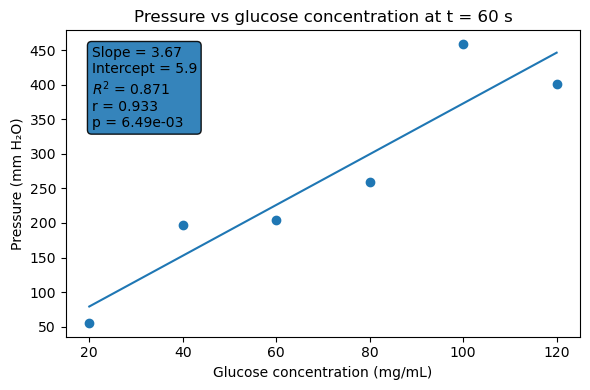

In [7]:
plot_pressure_vs_glucose(
    df=df_35_60,
    time_s=60,
    rep=1
)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

How would you interpret this graph?

What do the parameters in the legend tell you about the relationship?

Is there a realtionship between pressure and glucose concetration?

If yes, how strong or significant is this relationship?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Graph Interpretation </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

This looks like it might be a linear relationship.

The correlation coefficient r is close to one and has a low p-value, indicating statistically significant relationship between pressure and glucose concentration.

The R2 shows an acceptable fit of the data with the linear regression line, but it does indicate that there is some variance in the data.


</div>
</details>

Before moving one, we should query whether pressure at a fixed time point is the most appropriate way to describe this system.

### 7. Pressure rate as a measurement: moving beyond a fixed time point

#### 7.1. Performing a timecourse experiment and exploring the dataset

The single timepoint pressure measurement can show higher variance in the date, for example, because not all experiemnts are started at the same time.

By measuring the rate change of the pressure in a time-course experiment, this variability (**experimental bias**), can be mitigated.

Although it was not pointed out, when generating the synthetic dataset earlier, we did generate a time-series already.

This timeseries was stored in a variable called df_35.

Let's see how large that dataframe is:

In [8]:
df_35.shape

(102, 4)

This dataframe has the same 4 parameters (columns as the previous dataframe, but it now contains 102 rows (experimental datapoints) - these are the timecourse datapoints for all 6 glucose concentrations.

As this datafram is larger, let us only display the first 10 rows.

In [9]:
df_35.head(10)

,replicate,time_s,glucose_mg_ml,pressure_mmH2O
0,1,30.0,20.0,55.932848
1,1,30.0,40.0,170.443203
2,1,30.0,60.0,179.831912
3,1,30.0,80.0,238.351051
4,1,30.0,100.0,449.707650
5,1,30.0,120.0,403.513291
6,1,60.0,20.0,55.746566
7,1,60.0,40.0,197.160205
8,1,60.0,60.0,204.053640
9,1,60.0,80.0,259.565352


We can see the first timepoint for all 56 concentrations, and the second timepoint for some of these glucose concetrations.

#### 7.2. Visualising the timecourse data

Plotting the dataset will make the data easier to follow.

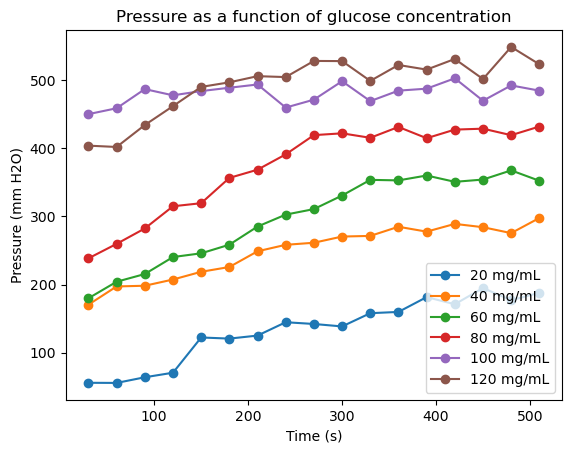

In [10]:
plot_pressure_timecourses(
    times_s=times_s,
    glucose_mg_ml=glucose_mg_ml,
    pressure=pressure_35,
    rep=0
)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What do you notice about this dataset?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Graph Interpretation </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

- There is some (experimental) noise in the datasets.
- Not taking hte noise into account, each dataset shows a regin of monotonous increase in pressure over time.
- Some datasets have an onset (lag phase, on the left) or a plateau (levelling off, on the right), or both.

Importantly, **the timecourse is not linear throughout!** The curves are **S-shaped curves** with **linear regions**.


*There will be opportunities to discuss the reasons for the S-shape curve forms in the Practical.*

</div>
</details>

#### 7.3. Determining the linear region and extracting pressure rates

To extract pressure rate changes, we have to work with the linear regions in the timecourse datasets.

To determine the linear regions, you have to decide where that linear regions starts and ends.


<div style="
    background-color: #e8f5e9;
    border-left: 6px solid #2e7d32;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

### ✍️ Activity

Below, is a section of code that allows you

1. Choose a **glucose concentration dataset** (*glucose_value*)
2. Choose a **start** and an **end timepoint** for the linear region (*t_min*, *t_max*)

When you execute the code, a graph will be plotted that shows 
- the selected linear region (orange datapoints)
- a regression through the lienar region (green line)
- the goodness of fit to the regression (R2)
- the correlation coefficient (r)

**Play with the timepoint parameters and explore how your choice changes the linear regression parameters.**

You can change and execute the plotting as often as you wish.

</div>

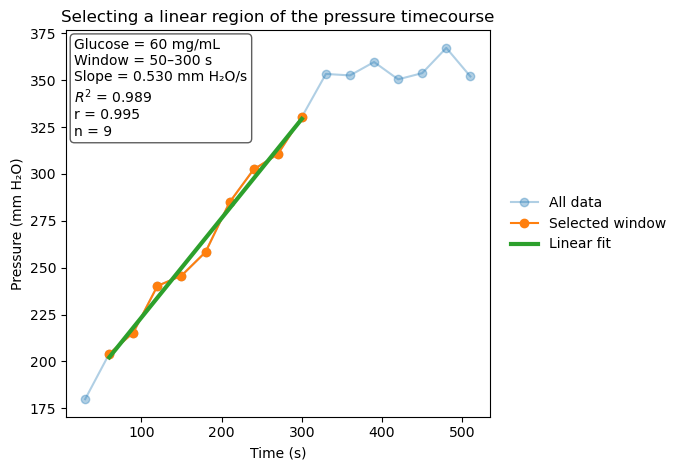

In [11]:
# STUDENT-CHOSEN PARAMETERS
glucose_value = 60   # mg/mL
t_min = 50          # s
t_max = 300          # s

plot_linear_region(
    times_s=times_s,
    glucose_mg_ml=glucose_mg_ml,
    pressure_35=pressure_35,
    glucose_value=glucose_value,
    t_min=t_min,
    t_max=t_max
)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What did you observe when changing the time-limits?

</div>

#### 7.4. Extracting pressure rates

Moving forward, to extract pressure rates, the following bounderies will be used to define the linear regions.

In [12]:
linear_windows = {
    20.0:  (150.0, 420.0),  # ignore early lag/jump; use steady rise
    40.0:  ( 60.0, 240.0),  # early-to-mid rise before flattening
    60.0:  ( 60.0, 300.0),  # long, clean rising segment
    80.0:  ( 60.0, 270.0),  # strong rise, stop before clear plateau
    100.0: ( 60.0, 180.0),  # mostly near-plateau later; keep early rise only
    120.0: ( 60.0, 150.0),  # rises early then plateaus/oscillates
}

We can now use this to extract only those linear regions from the datasets and plot the data and the lienar regressions through it.

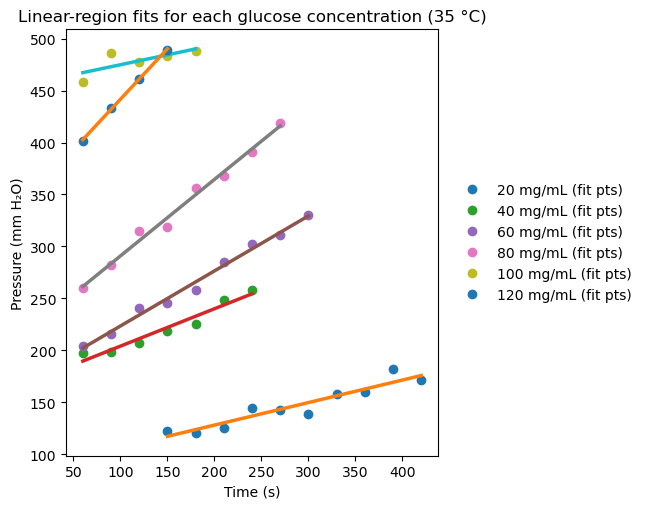

In [13]:
df_clip, rates_table = fit_linear_regions(df_35, linear_windows, rep=1)

plot_linear_fits_single_figure(df_clip, rates_table, rep=1)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What do you notice about this dataset?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Graph Interpretation </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

- ALmost all datasets have (visually) decent fits to linear regression.
- The higher glucose concentration samples have fewer datapoints than others. There is therefore less confidence in the accuracy of that data.
- The linear fit 100 mg/ml glucose sample seems very poor and the slope seems to not follow the trend of the other datapoints.

</div>
</details>

Below is a table that summarises the dataset constraints, fitting parameters and pressure rates (as slope_mmH2O_per_s) for each glucose concentration.

In [14]:
rates_table[["glucose_mg_ml", "t_min_s", "t_max_s", "n_points", "slope_mmH2O_per_s", "R2", "r"]]

,glucose_mg_ml,t_min_s,t_max_s,n_points,slope_mmH2O_per_s,R2,r
0,20.0,150.0,420.0,10,0.216857,0.889107,0.942925
1,40.0,60.0,240.0,7,0.359990,0.947804,0.973552
2,60.0,60.0,300.0,9,0.530265,0.989131,0.994551
3,80.0,60.0,270.0,8,0.736634,0.988751,0.994359
4,100.0,60.0,180.0,5,0.190772,0.552024,0.742983
5,120.0,60.0,150.0,4,0.972844,0.998782,0.999391


#### 7.5. Extracting pressure rates

Let us plot the pressure rate against the glucose concentration.

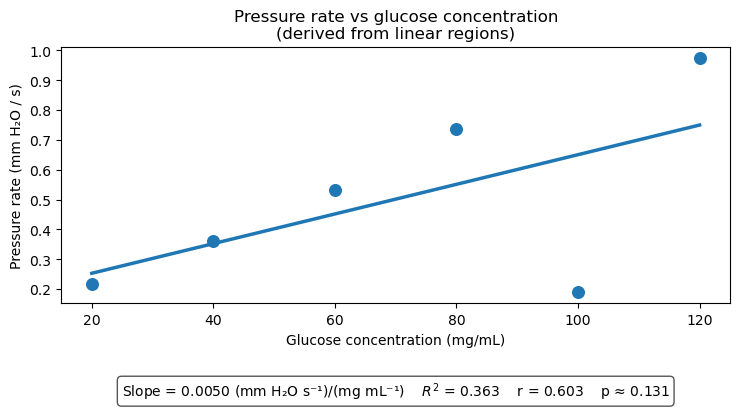

In [15]:
plot_pressure_rate_vs_glucose(rates_table)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What do you notice about this dataset?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Graph Interpretation </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

- Most datapoints seem to fall closely onto a line
- The 100 mg/ml dataset is far away from the line
- R2 and r are both poor - presumably because of the 100 mg/ml datapoint

</div>
</details>

#### 7.6. Outlier handling

We have good reason to assume that the 100 mg/ml datapoint might be an outlier.

It's linear region and linear regression were distinctly different from all other datasets. Furthermore, it is considerably removed from the linear regression in the pressure rate vs glucose concentration plot.

Nonetheless, removing a datapont form a dataset can never be undertaken lightly and must follow statistically well-founded and justified decision criteria. It must always be reported clearly!

To simplify the process, we will not look at statistical outlier analysis, but only check numerically 

1. Which datapoints have the highest deviation from the trendline.
2. Which datapooints have the largest influence on the slope of the regression line.

*Note that for proper statistical outlier analysis, one would need to generate replicates to understand the variance in the dataset.*

##### 7.6.1. Deviation from the linear regression line

The code below calculates how far each point is from the lienar regression line.

In [16]:
# extract data
x = rates_table["glucose_mg_ml"].to_numpy(dtype=float)
y = rates_table["slope_mmH2O_per_s"].to_numpy(dtype=float)

# fit full model
slope_full, intercept_full = np.polyfit(x, y, 1)
y_hat = slope_full * x + intercept_full
residuals = y - y_hat

residual_table = pd.DataFrame({
    "glucose_mg_ml": x,
    "rate_mmH2O_per_s": y,
    "fitted_rate": y_hat,
    "residual": residuals,
    "abs_residual": np.abs(residuals)
}).sort_values("glucose_mg_ml")

residual_table

,glucose_mg_ml,rate_mmH2O_per_s,fitted_rate,residual,abs_residual
0,20.0,0.216857,0.252752,-0.035895,0.035895
1,40.0,0.359990,0.352142,0.007848,0.007848
2,60.0,0.530265,0.451532,0.078733,0.078733
3,80.0,0.736634,0.550922,0.185712,0.185712
4,100.0,0.190772,0.650312,-0.459540,0.459540
5,120.0,0.972844,0.749702,0.223142,0.223142


The 100 mg/ml sample is furthers away form the line. Furthermore, it is more than twice as far from the line than the next point (120 mg/ml).

##### 7.6.2. Effect on the slope of the linear regression line

The code below calculates the strength of the influence each point hason the slope of the lienar regression line.

In [17]:
rows = []

for i in range(len(x)):
    mask = np.ones(len(x), dtype=bool)
    mask[i] = False

    slope_i, _ = np.polyfit(x[mask], y[mask], 1)

    rows.append({
        "removed_glucose_mg_ml": x[i],
        "slope_without_point": slope_i,
        "change_in_slope": slope_i - slope_full
    })

loo_table = pd.DataFrame(rows).sort_values("removed_glucose_mg_ml")
loo_table

,removed_glucose_mg_ml,slope_without_point,change_in_slope
0,20.0,0.004431,-0.000538
1,40.0,0.005017,0.000048
2,60.0,0.005107,0.000137
3,80.0,0.004646,-0.000324
4,100.0,0.007764,0.002794
5,120.0,0.001622,-0.003347


The 100 mg/ml and 120 mg/ml datapoints affect the slope of the line the most.

As the 100 mg/ml sample is hte only point that has a very stong effect on the slope of the trendline AND is the datapoint furtherst removed from the line, we have some numeric justification to treat this datapoint as an outlier.

Again, for proper outlier analysis, replicate measurements and further statistical analysis would be required that is beyond the scope of this workshop.

#### 7.7. Final dataset for pressure rate vs glucose concentration

Let us replot the graph of pressure rate vs glucose concentration without the 100 mg/ml datapoint.

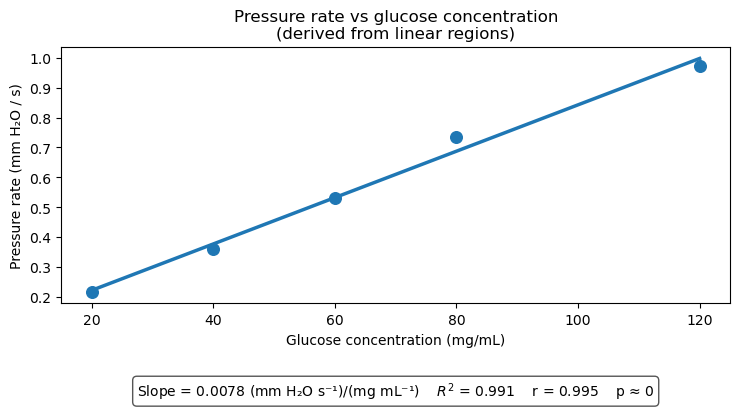

In [18]:
mask = x != 100

plot_pressure_rate_vs_glucose(
    rates_table[rates_table["glucose_mg_ml"] != 100]
)

This graph gives excellent R2 and r values

As plotted here, the values are better than those from the pressure vs glucose concentration graph at a pre-determined time point, suggesting that the pressure rate approach might mitigate some of the experimental bias from the system.

*Note: One could argue that both high conentration values - 100 mg/ml AND 120 mg/ml - are to be treated with caution becaue os the small linear regions compared to the other datasets.*

*Further replicates and analysis could well reveal that the pressure rate vs glucose concentration relationship is not fully linear at high glucose concentrations.*

### 8. From single-factor analysis to experimental design space

#### 8.1. Limitation of single-factor analysis

Up to this point, we have analysed the system by varying one factor at a time (glucose concentration) and by choosing how we measure the system (pressure at a fixed time point versus pressure rate).

In reality, the conclusions we draw from such analyses are often local — they hold only within a specific region of the experimental conditions explored.

However, real experimental systems rarely depend on a single variable. In practice, multiple experimental factors change simultaneously, and the behaviour we observe often depends on where we are in the overall experimental space.

In this section, we step back from detailed analysis to introduce the idea of an experimental design space.

#### 8.2. Experimental design as a multi-dimensional space

When we vary only a single factor at a time and keep all others constant, we are essentially moving along a single axis in the design space.

Below, two graphs illustrate the implications of the one-factor-at-a-time approach versus another approach called factorial sampling.

**Factorial sampling** explores combinations of multiple experimental factors simultaneously, rather than varying one factor at a time.
This allows interactions between variables to be detected and ensures that conclusions are not restricted to a narrow region of the design space.

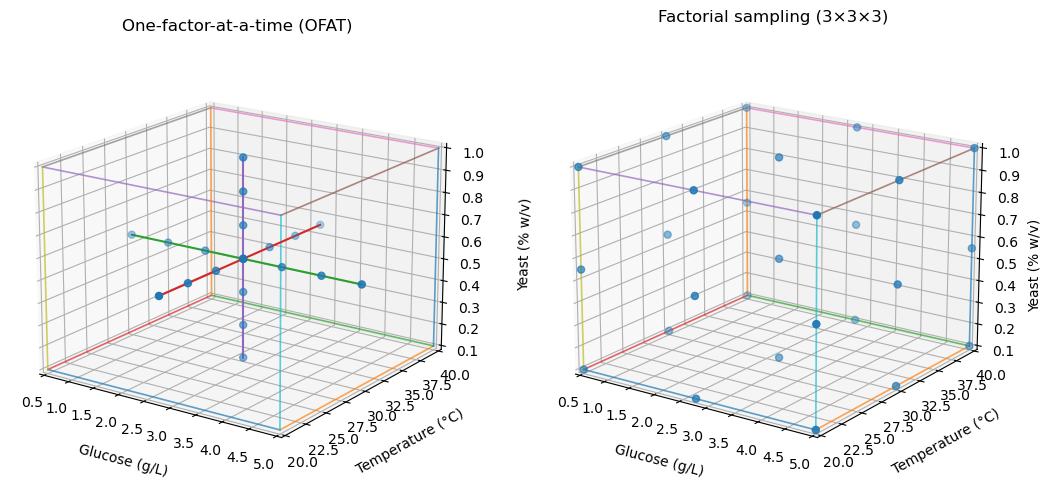

In [19]:
# Design-space figure (SVG): OFAT (left) vs Factorial (right)
# Axes: Glucose concentration, Temperature, Yeast concentration

import numpy as np
import matplotlib.pyplot as plt

glucose = (0.5, 5.0)
temp    = (20.0, 40.0)
yeast   = (0.1, 1.0)

def cube_edges(xlim, ylim, zlim):
    x0, x1 = xlim; y0, y1 = ylim; z0, z1 = zlim
    corners = np.array([
        [x0,y0,z0],[x1,y0,z0],[x1,y1,z0],[x0,y1,z0],
        [x0,y0,z1],[x1,y0,z1],[x1,y1,z1],[x0,y1,z1]
    ])
    edges = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]
    return corners, edges

def add_cube(ax, xlim, ylim, zlim):
    c, e = cube_edges(xlim, ylim, zlim)
    for i, j in e:
        ax.plot([c[i,0], c[j,0]],
                [c[i,1], c[j,1]],
                [c[i,2], c[j,2]],
                linewidth=1.2, alpha=0.7)

# Sampling
levels = 3
gx = np.linspace(*glucose, levels)
ty = np.linspace(*temp, levels)
yz = np.linspace(*yeast, levels)
G, T, Y = np.meshgrid(gx, ty, yz, indexing="ij")
factorial_points = np.column_stack([G.ravel(), T.ravel(), Y.ravel()])

g0, t0, y0 = map(np.mean, [glucose, temp, yeast])
n = 7
ofat_g = np.column_stack([np.linspace(*glucose, n), np.full(n, t0), np.full(n, y0)])
ofat_t = np.column_stack([np.full(n, g0), np.linspace(*temp, n), np.full(n, y0)])
ofat_y = np.column_stack([np.full(n, g0), np.full(n, t0), np.linspace(*yeast, n)])
ofat_points = np.vstack([ofat_g, ofat_t, ofat_y])

# Plot
fig = plt.figure(figsize=(11, 6))

# LEFT: OFAT
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
add_cube(ax1, glucose, temp, yeast)
ax1.scatter(ofat_points[:,0], ofat_points[:,1], ofat_points[:,2], s=26)
ax1.plot(ofat_g[:,0], ofat_g[:,1], ofat_g[:,2])
ax1.plot(ofat_t[:,0], ofat_t[:,1], ofat_t[:,2])
ax1.plot(ofat_y[:,0], ofat_y[:,1], ofat_y[:,2])

ax1.set_title("One-factor-at-a-time (OFAT)")
ax1.set_xlabel("Glucose (g/L)", labelpad=10)
ax1.set_ylabel("Temperature (°C)", labelpad=10)
ax1.set_zlabel("Yeast (% w/v)", labelpad=14, rotation=90)
ax1.set_xlim(glucose); ax1.set_ylim(temp); ax1.set_zlim(yeast)
ax1.view_init(elev=18, azim=-55)

# RIGHT: Factorial
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
add_cube(ax2, glucose, temp, yeast)
ax2.scatter(factorial_points[:,0], factorial_points[:,1], factorial_points[:,2], s=26)

ax2.set_title(f"Factorial sampling ({levels}×{levels}×{levels})", pad=12)
ax2.set_xlabel("Glucose (g/L)", labelpad=10)
ax2.set_ylabel("Temperature (°C)", labelpad=10)

# --- robust z-label (never clipped): draw as 2D text instead of 3D label ---
ax2.set_zlabel("")  # disable the fragile 3D z-label
ax2.text2D(
    1.06, 0.5, "Yeast (% w/v)",
    transform=ax2.transAxes,
    rotation=90,
    va="center", ha="left"
)

ax2.set_xlim(glucose); ax2.set_ylim(temp); ax2.set_zlim(yeast)
ax2.view_init(elev=18, azim=-55)

plt.subplots_adjust(left=0.06, right=0.96, wspace=0.18)

plt.savefig("design_space_ofat_vs_factorial.svg", format="svg", bbox_inches="tight")
plt.show()

The figure above illustrates a three-dimensional experimental design space. The space is defined by **glucose concentration**, **temperature**, and **yeast concentration**. Each point represents a possible experimental condition within the allowed ranges of these factors.

The **one-factor-at-a-time (OFAT)** strategy (left) explores each variable individually while holding the others constant. While this can be appropriate in simple systems where only one parameter is explored, for higher dimensional parameter space, this approch ignores a large part of the design space (i.e., naything not on the cardinal axes). 

The **factorial design** (right) samples combinations of all factors simultaneously. This provides broader and more systematic coverage of the design space, and enables interactions between variables to be identified.

#### 8.3. The effect of temperature as a second experimental factor

Let's explore how another factor, temperature, affects the pressure rate in the system.

##### 8.3.1. Creating a temperature dependent dataset

First, we create another synthetic dataset from our function.

In [20]:
# ---- define design space ----
glucose_vals = np.array([20, 40, 60, 80, 100, 120], dtype=float)
temperature_vals = np.array([20, 25, 30, 35, 40], dtype=float)

# ---- generate full dataset ----
times_s, glucose_mg_ml, temps_C, pressure_T = generate_pressure_dataset_with_temperature(
    glucose_mg_ml=glucose_vals,
    temps_C=temperature_vals,
    n_reps=1,
    seed=42,
    exclude_base_temp=False,
    squeeze_singletons=False
)

# ---- choose a fixed linear window (seconds) ----
t_min, t_max = 120.0, 300.0

rates = []

for g_idx, g in enumerate(glucose_mg_ml):
    for t_idx, T in enumerate(temps_C):

        y = pressure_T[0, :, g_idx, t_idx]   # (time,)
        x = times_s

        mask = (x >= t_min) & (x <= t_max)
        xw = x[mask]
        yw = y[mask]

        if len(xw) >= 2:
            slope, intercept, r2, r = linregress_np(xw, yw)
        else:
            slope = np.nan

        rates.append({
            "glucose_mg_ml": g,
            "temperature_C": T,
            "pressure_rate_mmH2O_per_s": slope
        })

df_rates_2d = pd.DataFrame(rates)

##### 8.3.2. Visualising the data in scatterplots

The code below calls a function that let's us plot the time-dependent change in pressure at different tempeartures for a fixed glucose cocnentration (60 mg/ml).

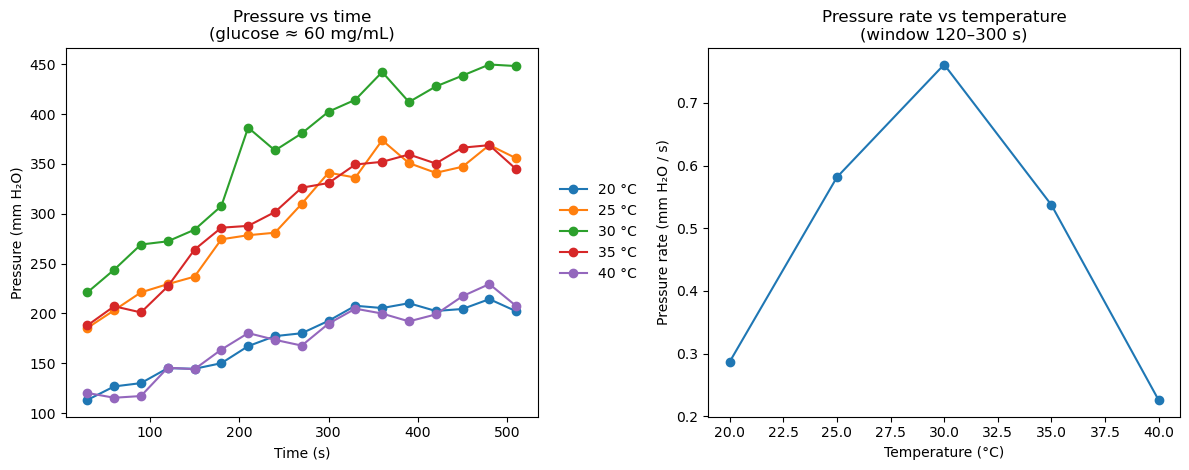

In [21]:
plot_temperature_effects_at_glucose(
    times_s=times_s,
    glucose_mg_ml=glucose_mg_ml,
    temps_C=temps_C,
    pressure_T=pressure_T,
    glucose_value=60.0,
    rep=0,
    t_min=120.0,
    t_max=300.0
)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What do you notice about this dataset?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Graph Interpretation </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

- Temperature affects the yeast activity, and must be either factored in or held constant.
- The optimum reaction tempearture is 30 °C.
- Reactions still take place outside the optimum tempearture, but at reduced rates.

</div>
</details>

##### 8.3.3. 2D Heatmap visualisation

If temperature dependent timecourses are collected for different glucose concentrations, we have a two-dimension design space that can be illustrated, for example, in a heatmap such as the one below.

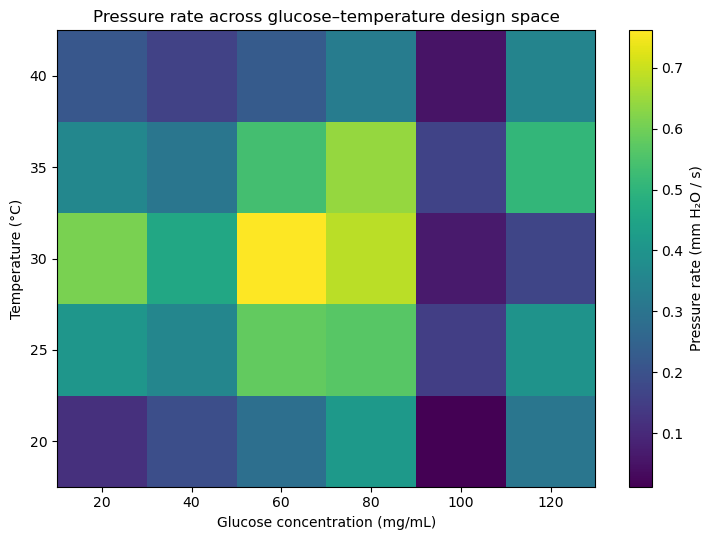

In [22]:
plot_pressure_rate_heatmap(df_rates_2d)

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

What do you notice about this dataset?

</div>

<details style="margin-top: 12px;">

<summary>
<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 10px 14px;
    border-radius: 6px;
    font-weight: bold;
    cursor: pointer;
">
<strong>▶ Graph Interpretation </strong>
</div>
</summary>


<div style="
    background-color: #e9f7fb;
    border-left: 6px solid #17a2b8;
    padding: 12px 16px;
    border-radius: 6px;
    margin-top: 10px;
">

- The heatmap shows areas of highest activity in the centre - 60 mg/ml - 80 mg/ml glucose and 30 °C.
- The odd behaviour of the 100 mg/ml sample is visible for evey temperature (likely an artifact of the sytnehtic sample dataset generation).

</div>
</details>

#### 8.4. The effect of temperature as a second experimental factor

By adding the amount of yeast as a third variable, we enter a three dimensional design space.

##### 8.4.1. Creating a yeast activity, temperature and glucose concentration dependent dataset

The code below generates such a 3D synthetic dataset and shows the first 5 entries in the dataframe.

In [23]:
glucose_vals = [20, 40, 60, 80, 100, 120]
temperature_vals = [20, 25, 30, 35, 40]
yeast_vals = [0.5, 1.0, 2.0]   # relative yeast concentration (arbitrary units)

df_rates_3d = generate_rates_3d_design_space(
    glucose_vals=glucose_vals,
    temperature_vals=temperature_vals,
    yeast_vals=yeast_vals,
    t_min=120.0,
    t_max=300.0,
    seed=42
)

df_rates_3d.head()

,glucose_mg_ml,temperature_C,yeast_rel,pressure_rate_mmH2O_per_s
0,20.0,20.0,0.5,0.195730
1,20.0,25.0,0.5,0.568086
2,20.0,30.0,0.5,0.808401
3,20.0,35.0,0.5,0.516494
4,20.0,40.0,0.5,0.290173


##### 8.4.2. Visualising the data

We can plot the data for mthis dataframe in a 3D space.

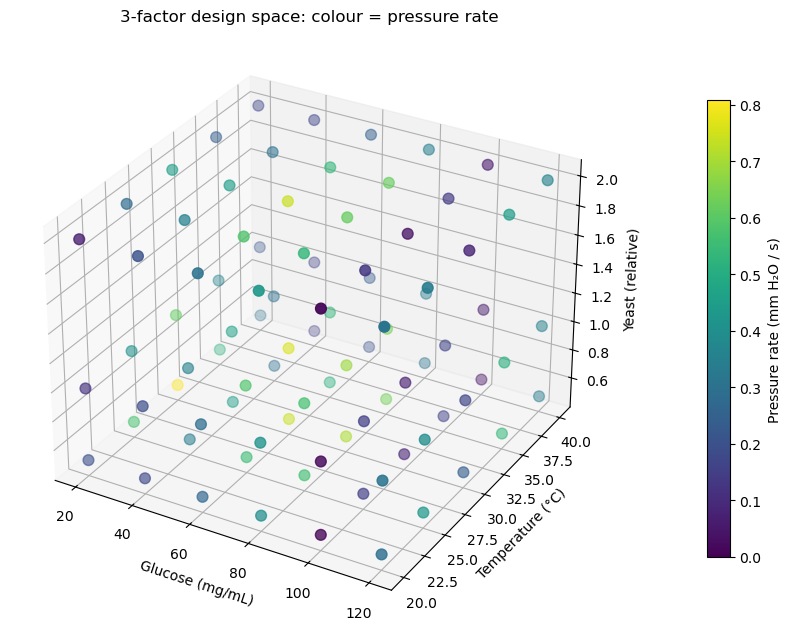

In [24]:
plot_3d_design_space_rates(df_rates_3d)


<div style="
    background-color: #e8f5e9;
    border-left: 6px solid #2e7d32;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

### ✍️ Activity

Below, is a section of code that allows you select a 2D slice of the 3D graph above.

Choose a **yeast activity value** (*chosen_yeast*), which is a computational parameter that reflects the amount of yeast in the system to see the heatmap and profiles for this yeast activity.

You can change and execute the plotting as often as you wish.

</div>

Available yeast activity levels (relative): [np.float64(0.5), np.float64(1.0), np.float64(2.0)]


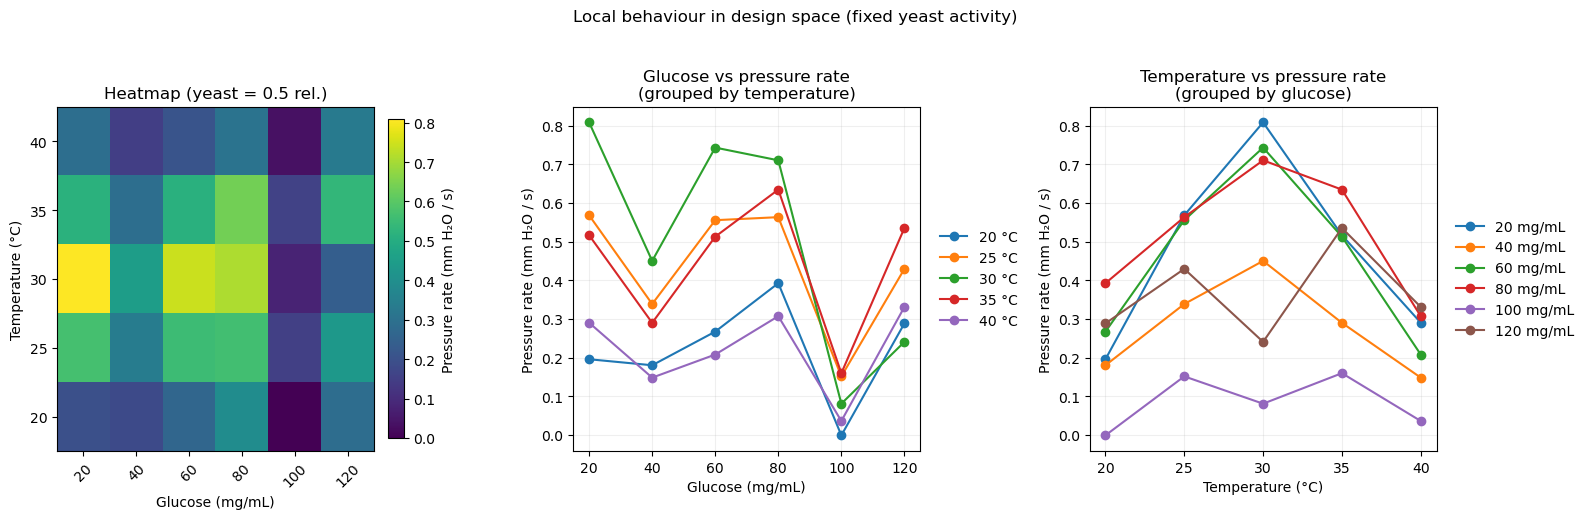

In [25]:
# Available discrete yeast activity levels (relative):
yeast_options = sorted(df_rates_3d["yeast_rel"].unique())
print("Available yeast activity levels (relative):", yeast_options)

# STUDENT: type ONE of these values: 0.5, 1.0, 2.0
chosen_yeast = 0.5

plot_design_space_summary_for_yeast(
    df_rates_3d=df_rates_3d,
    yeast_activity=chosen_yeast
)

Note how this allows exploration of effects and trends of multiple parameters at the same time.

<div style="
    background-color: #fff3cd;
    border-left: 6px solid #ffbf00;
    padding: 12px 16px;
    border-radius: 6px;
    margin: 12px 0;
">

🛑 **STOP & THINK**

Did you observe anything of note?
How do the parameters act together?

</div>

## 9. Concluding Remarks

### 9.1. Concepts covered

In this workbook, we covered a number of basic concepts for experimental design.

We though about

**Framing the experiment**
- Scientific question
- Outcome / response variable
- Experimental assumptions

**Variables and parameters**
- Experimental parameters (factors)
- Controllable variables
- Fixed variables

**Design thinking**
- Design space
- Parameter ranges
- Constraints
- Bias

**Understanding behaviour**
- Parameter interactions
- Interpretability


### 9.2. Take away messages

By the end of this workbook, you should understand experimental design as a way of thinking, not just a set of techniques.

In particular:

- Experiments start with a scientific question, not with data or optimisation
- Parameters define a design space, not a single “best” condition
- Good design happens before data collection, through reasoning about ranges, interactions, and constraints
- Some parameters matter only in combination, not in isolation
- Early experiments are for learning, not optimisation
- Design choices determine what conclusions are possible
- These principles are generalisable and apply to experimental research in general.

### 9.3. Next Steps

The ideas in this workbook form the foundation for more advanced experimental design and analysis such as

- Structured experimental designs
- Design of Experiment approaches
- Modelling experimental outcomes
- Design space mapping
- Data-driven experimentation
- Optimisation
